# Word and Feature frequency Analysis

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import tensorflow as tf
import os 
# for some models GPU capacity was not enough hence trained those models by disabling GPU with below line
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
from tensorflow.keras.layers import Dense,Flatten,Embedding,Concatenate
from tensorflow.keras.layers import Conv1D,MaxPooling1D,Dropout,Conv2D,MaxPooling2D
from tensorflow.keras.layers import Input,Activation,LSTM,BatchNormalization
from tensorflow.keras.models import Model
from sklearn.preprocessing import Normalizer
from sklearn.metrics import roc_curve,roc_auc_score,f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.preprocessing import minmax_scale,MinMaxScaler
import tensorflow_text as text
import pathlib
import tensorflow_addons as tfa

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
# reading preprocessed data

structured_data = pickle.load(open("structured_data.pkl","rb"))
print("Shape of created dataframe is : ",structured_data.shape)
print("Shape of created featrure matrix in feat_mat column is : ",structured_data['feat_mat'].values[1].shape)

Shape of created dataframe is :  (10956, 6)
Shape of created featrure matrix in feat_mat column is :  (500, 310, 1)


In [3]:
# for missing data for any company, on a particular day, was assigned 0 as sign change label
# hence removing those to have cleaned data
#structured_data = structured_data[structured_data.sign_change != 0]


# changing -1 & 1 to 0 & 1 to have binary crossentropy as loss and sigmoid as final layer activation.
#structured_data['sign_change'] = structured_data.sign_change.apply(lambda x:0 if x==-1 else 1)

structured_data = structured_data.sort_values(by=['post_date','company_name'])

structured_data['tweet_text_len'] = structured_data.tweet_text.apply(lambda x:len(x.split()))

structured_data.head()

post_date                                         tweet_text  \
0     2015-01-01  aapl store line sapporo japan lucky bag pic ht...   
1826  2015-01-01  aapl store line sapporo japan lucky bag pic ht...   
9130  2015-01-01  aapl store line sapporo japan lucky bag pic ht...   
3652  2015-01-01  aapl store line sapporo japan lucky bag pic ht...   
7304  2015-01-01  aapl store line sapporo japan lucky bag pic ht...   

     company_name                                           feat_mat  \
0            AAPL  [[[0.0031695721077654], [0.0020060180541624], ...   
1826         AMZN  [[[0.0031695721077654], [0.0020060180541624], ...   
9130         GOOG  [[[0.0031695721077654], [0.0020060180541624], ...   
3652        GOOGL  [[[0.0031695721077654], [0.0020060180541624], ...   
7304         MSFT  [[[0.0031695721077654], [0.0020060180541624], ...   

      change_label sign_change  tweet_text_len  
0              0.0           1             501  
1826           0.0           1             501  
9130           0.0           1             501  
3652           0.0           1             501  
7304           0.0           1             501

### Since the data split is being done on temporal basis, there is no randomness in train test split. Hence we will get exactly same train and validation sets that we trained our models on.

In [6]:
# the data that we have is from '2015-01-01' to '2019-12-31'
# Hence taking last 6 months as test data and 4 years, 6 months of training data from the dataset
train_data = structured_data[structured_data.post_date < '2019-06-01']
test_data = structured_data[structured_data.post_date >= '2019-06-01']


# getting train data for all models
# two class labels are there, one is magnitude of % change
# while second one is sign of change (values 0 or 1 : 0 - negative change, 1 - positive change)
y_train_change = train_data['change_label'].values
y_train_sign = train_data['sign_change'].values
y_train_sign = y_train_sign.astype('int')
x_train_text = train_data['tweet_text'].values
'''x_train_tweet_vec = train_data['tweet_vec'].values
x_train_tweet_vec = list(x_train_tweet_vec)
x_train_tweet_vec = np.array(x_train_tweet_vec)'''
x_train_feat = list(train_data['feat_mat'].values)
x_train_feat = np.array(x_train_feat)
x_train_company = train_data['company_name'].values

# getting test data for all models
y_test_change = test_data['change_label'].values
y_test_sign = test_data['sign_change'].values
y_test_sign = y_test_sign.astype('int')
x_test_text = test_data['tweet_text'].values
'''x_test_tweet_vec = test_data['tweet_vec'].values
x_test_tweet_vec = list(x_test_tweet_vec)
x_test_tweet_vec = np.array(x_test_tweet_vec)'''
x_test_feat = list(test_data['feat_mat'].values)
x_test_feat = np.array(x_test_feat)
x_test_company = test_data['company_name'].values

print("Number of data points in train data are :",train_data.shape[0])
print("Number of data points in train data are :",test_data.shape[0])

Number of data points in train data are : 9672
Number of data points in train data are : 1284


In [7]:
# loading saved tokenizer output

[vocab_size_text,train_text,test_text] = pickle.load(open("bert_tokens.pkl","rb"))

In [8]:
# We don't need to use subwordtokenizer here since these company names are standard
# and these will not be changed while giving as inputs


# creating tokens for company names
tokenizer = Tokenizer()                   # creating tokenizer object
tokenizer.fit_on_texts(x_train_company) 
vocab_size_company = len(tokenizer.word_index) + 1

# getting tokenized train data
train_comp = np.array(tokenizer.texts_to_sequences(x_train_company))

# getting tokenized test data
test_comp = np.array(tokenizer.texts_to_sequences(x_test_company))

# Model Definition 

In [13]:
np.random.seed(0)
tf.random.set_seed(0)

# clearing previous session if it exists.
tf.keras.backend.clear_session()

# essay feature
input_text = Input(shape=(5000,),name="Tweet text input")

embedding_text = Embedding(vocab_size_text, 100)(input_text)


conv11 = Conv1D(64,kernel_size = 20,padding='same')(embedding_text)

maxpool11 = MaxPooling1D(10)(conv11)


conv12 = Conv1D(64,kernel_size = 10,padding='same')(embedding_text)

maxpool12 = MaxPooling1D(10)(conv12)


concat1 = Concatenate()([maxpool11,maxpool12])

flatten1 = Flatten()(concat1)



input_feat = Input(shape=(500,310,1),name="feature_matrix input")

conv21 = Conv2D(64,(3,3),padding='same')(input_feat)

pool21 = MaxPooling2D()(conv21)

flatten2 = Flatten()(pool21)



input_company = Input(shape=(1,),name="Company_name")

embedding_company = Embedding(vocab_size_company, 6)(input_company)

flatten3 = Flatten()(embedding_company)



concat = Concatenate()([flatten1,flatten2,flatten3])

dense_layer1 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(concat)

dense_layer2 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer1)

dense_layer3 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer2)

dense_layer4 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer3)

dense_layer41 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer4)

dense_layer41 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer41)

output_sign = Dense(1,activation = 'sigmoid',name="sign_prediction")(dense_layer41)

dense_layer42 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer4)

dense_layer42 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer42)

output_change = Dense(1,activation='relu',name="Change_prediction")(dense_layer42)


model = Model(inputs=[input_text,input_feat,input_company]
              ,outputs=[output_change,output_sign])

# Compiling Model

In [14]:
# Referred and implemented Piece wise Decay using below link
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PiecewiseConstantDecay


step = tf.Variable(0, trainable=False)   # Variable to store and get step number in training

# some numbers are multiples of 301 cause these are steps per epoch with batch size 32
boundaries = [10,50,100, 602, 903]
values = [1e-6,1e-5, 1e-4, 1e-4, 0.5e-4, 1e-5]
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)
learn_rate = learning_rate_fn(step)


adamw_opt = tfa.optimizers.AdamW(learning_rate=learn_rate,weight_decay=0.0001)


# compiling with adam optimizer and loss as categorical crossentropy
model.compile(optimizer=adamw_opt,
              loss=[tf.keras.losses.mean_squared_error,tf.keras.losses.binary_crossentropy])

# Loading Trained weights

In [15]:
model.load_weights('model4_save\weights-05-2.1848.hdf5')

prediction = model.predict([test_text,x_test_feat,test_comp])

deviation = []
for i in range(len(prediction[0])):
    deviation.append(abs(prediction[0][i]-y_test_change[i]))
print("Mean Deviation for % change in closing prices is : ",np.mean(deviation))

count = 0
sign_pred = [1 if i[0]>=0.5 else 0 for i in prediction[1]]
for i in range(0,len(prediction[1])):
    if sign_pred[i] == y_test_sign[i]:
        count += 1
        
print("Number of correct signs predicted out of {} are : {}".format(len(y_test_sign),count))

Mean Deviation for % change in closing prices is :  0.85438716
Number of correct signs predicted out of 1284 are : 888


# Performance Analysis

#### <li> There are two predictions from model and those are chnage prediction and sign_prediction. </li>
#### <li> Let us analyze model performance with respect to each output. </li>

# 1. Change_value_prediction

<li> Let us first analyze the percentile values for deviation from actual values. </li>

In [16]:
deviation = np.array(deviation)

for i in range(0,100,10):
    print("{}th percentile value for deviation is : {}".format(i,np.percentile(deviation,i)))

0th percentile value for deviation is : 0.0007213354110717773
10th percentile value for deviation is : 0.20876576900482177
20th percentile value for deviation is : 0.38617049455642705
30th percentile value for deviation is : 0.49564359486103055
40th percentile value for deviation is : 0.6273788213729861
50th percentile value for deviation is : 0.7295406758785248
60th percentile value for deviation is : 0.8128521323204041
70th percentile value for deviation is : 0.9819872438907623
80th percentile value for deviation is : 1.1420538187026978
90th percentile value for deviation is : 1.3895881414413456


<li> Based on the percentile values, let us set a threshold as follows: </li>
<table>
    <tr> 
        <td><b>Category</b></td>
        <td><b>Deviation Value</b></td>
    </tr>
    <tr>
        <td> Best </td>
        <td> <= 0.40 </td>
    </tr>
    <tr>
        <td> Medium </td>
        <td> 0.40 > & <= 1.0  </td>
    </tr>
    <tr>
        <td> Worst </td>
        <td> > 1.0 </td>
    </tr>
</table>

In [17]:
best_indices = []  # empty list to store best prediction indices in test data
medium_indices = []  # empty list to store medium prediction indices in test data
worst_indices = []  # empty list to store worst prediction indices in test data

# Loop to iterate over all deviations and getting all indices
for i in range(len(deviation)):
    temp = deviation[i]
    if temp <= 0.4:
        best_indices.append(i)
    elif temp > 0.4 and temp <= 1:
        medium_indices.append(i)
    else:
        worst_indices.append(i)
        
best_indices = np.array(best_indices)
medium_indices = np.array(medium_indices)
worst_indices = np.array(worst_indices)

## 1.1 Getting Word and Feature frequencies

#### 1.1.1 Best predictions

In [18]:
# Referred wordcloud from here : https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


# function to count word occurances
def count_words(str):
    word_count = dict()
    words = str.split()

    for word in tqdm(words):
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1

    return word_count

words = ''
stopwords = set(STOPWORDS)

# empty lists to store feature related information
best_neg_count = []
best_neu_count = []
best_pos_count = []
best_URL_flag = []
best_hashtags_flag = []
best_mention_flag = []

for i in tqdm(best_indices):
    best_neg_count.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,6]))
    best_neu_count.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,7]))
    best_pos_count.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,8]))
    best_URL_flag.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,3]))
    best_hashtags_flag.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,4]))
    best_mention_flag.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,5]))
    temp = test_data.iloc[i]['tweet_text']
    temp = temp.replace('aapl','')
    temp = temp.replace('amzn','')
    temp = temp.replace('tsla','')
    temp = temp.replace('googl','')
    temp = temp.replace('goog','')
    temp = temp.replace('msft','')
    temp = temp.replace('apple','')
    temp = temp.replace('amazon','')
    temp = temp.replace('tesla','')
    temp = temp.replace('google','')
    temp = temp.replace('microsoft','')
    words += " "+temp+" "   # Getting all words from test essay data to create wordcloud

word_count = count_words(words)

best_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)

best_words = np.array(list(word_count.keys()))
best_count = np.array(list(word_count.values()))

best_ind = np.argsort(best_count)

print("Top 10 words for best prediction are : \n\n")

for i in range(-1,-11,-1):
    print("word : ",best_words[best_ind[i]],"      ","Count : ",best_count[best_ind[i]])
    
    
print("\n\nTop 10 rare words for best prediction are : \n\n")

for i in range(11):
    print("word : ",best_words[best_ind[i]],"      ","Count : ",best_count[best_ind[i]])

100%|███████████████████████████████████████████████████████████████████| 1252692/1252692 [00:00<00:00, 2722784.61it/s]


Top 10 words for best prediction are : 


word :  fb        Count :  12624
word :  nflx        Count :  9312
word :  not        Count :  8309
word :  spy        Count :  7362
word :  1        Count :  6852
word :  3        Count :  5677
word :  amd        Count :  5328
word :  qqq        Count :  5166
word :  nvda        Count :  5152
word :  baba        Count :  4765


Top 10 rare words for best prediction are : 


word :  radarsdisruptive        Count :  1
word :  lark        Count :  1
word :  imosignificant        Count :  1
word :  securedq        Count :  1
word :  commerzbank        Count :  1
word :  huanglike        Count :  1
word :  austrian        Count :  1
word :  homicidereminder        Count :  1
word :  everyoneappears        Count :  1
word :  dellgood        Count :  1
word :  yropen        Count :  1


#### 1.1.2 Medium Predictions

In [19]:
words = ''
stopwords = set(STOPWORDS)

medium_neg_count = []
medium_neu_count = []
medium_pos_count = []
medium_URL_flag = []
medium_hashtags_flag = []
medium_mention_flag = []

for i in tqdm(medium_indices):
    medium_neg_count.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,6]))
    medium_neu_count.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,7]))
    medium_pos_count.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,8]))
    medium_URL_flag.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,3]))
    medium_hashtags_flag.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,4]))
    medium_mention_flag.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,5]))
    temp = test_data.iloc[i]['tweet_text']
    temp = temp.replace('aapl','')
    temp = temp.replace('amzn','')
    temp = temp.replace('tsla','')
    temp = temp.replace('googl','')
    temp = temp.replace('goog','')
    temp = temp.replace('msft','')
    temp = temp.replace('apple','')
    temp = temp.replace('amazon','')
    temp = temp.replace('tesla','')
    temp = temp.replace('google','')
    temp = temp.replace('microsoft','')
    words += " "+temp+" "   # Getting all words from test essay data to create wordcloud

word_count = count_words(words)


medium_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)

medium_words = np.array(list(word_count.keys()))
medium_count = np.array(list(word_count.values()))

medium_ind = np.argsort(medium_count)

print("Top 10 words for medium prediction are : \n\n")

for i in range(-1,-11,-1):
    print("word : ",medium_words[medium_ind[i]],"      ","Count : ",medium_count[medium_ind[i]])
    
    
print("\n\nTop 10 rare words for medium prediction are : \n\n")

for i in range(10):
    print("word : ",medium_words[medium_ind[i]],"      ","Count : ",medium_count[medium_ind[i]])

100%|███████████████████████████████████████████████████████████████████| 2501808/2501808 [00:00<00:00, 2698589.36it/s]


Top 10 words for medium prediction are : 


word :  fb        Count :  24865
word :  nflx        Count :  17944
word :  not        Count :  17669
word :  spy        Count :  15266
word :  1        Count :  12680
word :  3        Count :  11782
word :  amd        Count :  11305
word :  qqq        Count :  10353
word :  q        Count :  10272
word :  nvda        Count :  9469


Top 10 rare words for medium prediction are : 


word :  radarsdisruptive        Count :  1
word :  yearsest        Count :  1
word :  stocksroad        Count :  1
word :  900mthe        Count :  1
word :  likeykt        Count :  1
word :  xommenstruation        Count :  1
word :  lotsdear        Count :  1
word :  meetingknow        Count :  1
word :  survivelast        Count :  1
word :  perilously        Count :  1


#### 1.1.3 Worst Predictions

In [20]:
words = ''
stopwords = set(STOPWORDS)

worst_neg_count = []
worst_neu_count = []
worst_pos_count = []
worst_URL_flag = []
worst_hashtags_flag = []
worst_mention_flag = []

for i in tqdm(worst_indices):
    worst_neg_count.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,6]))
    worst_neu_count.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,7]))
    worst_pos_count.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,8]))
    worst_URL_flag.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,3]))
    worst_hashtags_flag.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,4]))
    worst_mention_flag.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,5]))
    temp = test_data.iloc[i]['tweet_text']
    temp = temp.replace('aapl','')
    temp = temp.replace('amzn','')
    temp = temp.replace('tsla','')
    temp = temp.replace('googl','')
    temp = temp.replace('goog','')
    temp = temp.replace('msft','')
    temp = temp.replace('apple','')
    temp = temp.replace('amazon','')
    temp = temp.replace('tesla','')
    temp = temp.replace('google','')
    temp = temp.replace('microsoft','')
    words += " "+temp+" "   # Getting all words from test essay data to create wordcloud

word_count = count_words(words)


worst_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)

worst_words = np.array(list(word_count.keys()))
worst_count = np.array(list(word_count.values()))

worst_ind = np.argsort(worst_count)

print("Top 10 words for worst prediction  are : \n\n")

for i in range(-1,-11,-1):
    print("word : ",worst_words[worst_ind[i]],"      ","Count : ",worst_count[worst_ind[i]])
    
    
print("\n\nTop 10 rare words for worst prediction are : \n\n")

for i in range(10):
    print("word : ",worst_words[worst_ind[i]],"      ","Count : ",worst_count[worst_ind[i]])

100%|███████████████████████████████████████████████████████████████████| 1924338/1924338 [00:00<00:00, 2715497.14it/s]


Top 10 words for worst prediction  are : 


word :  fb        Count :  19697
word :  not        Count :  13016
word :  nflx        Count :  12884
word :  spy        Count :  11308
word :  1        Count :  9808
word :  3        Count :  8917
word :  amd        Count :  8255
word :  qqq        Count :  8007
word :  q        Count :  7358
word :  nvda        Count :  7321


Top 10 rare words for worst prediction are : 


word :  macbooks        Count :  1
word :  wtop        Count :  1
word :  takeif        Count :  1
word :  cncgoing        Count :  1
word :  agomid        Count :  1
word :  landscapehappy        Count :  1
word :  risejoin        Count :  1
word :  writtenbetter        Count :  1
word :  thanksgearing        Count :  1
word :  speaksgoing        Count :  1


#### We can observe some numbers are also there instead of words. These were kept intensionally since stock market is all about numbers. Hence tried to extract information with numbers as well.

<li> With the output obtained from all three categories, words fb,nflx,not,spy,1,3,amd,qqq,q were most frequence in all three categories while market was the word which made it to top 10 in worst category. </li>
<li> While least frequent words can not be judged with just 10 words, since there will be many words with count 1 hence let us analyze those with wordcloud. </li>

### 1.2 Plotting wordcloud for Most Frequent Words

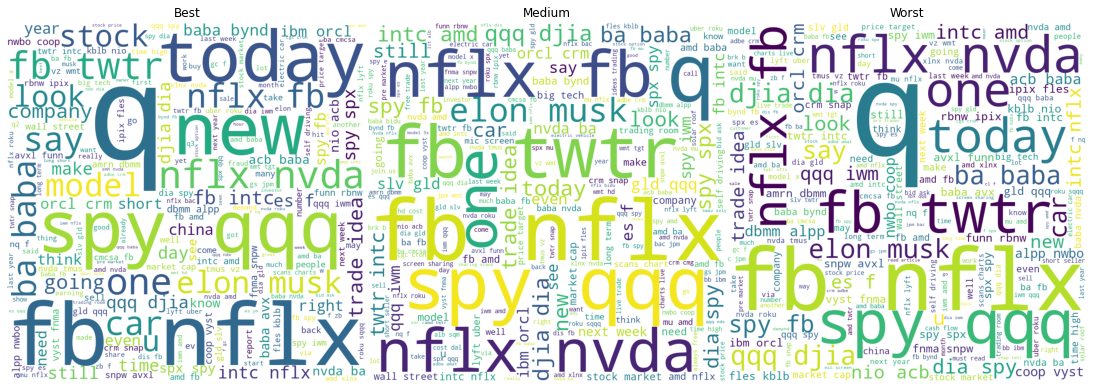

In [21]:
plt.figure(figsize=(15,30))
plt.subplot(1,3,1)
plt.imshow(best_wordcloud)
plt.title("Best")
plt.axis("off")
plt.tight_layout(pad = 0)

plt.subplot(1,3,2)
plt.imshow(medium_wordcloud)
plt.title("Medium")
plt.axis("off")
plt.tight_layout(pad = 0)

plt.subplot(1,3,3)
plt.imshow(worst_wordcloud)
plt.title("Worst")
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

<li> With this wordcloud, we can observe there are many words common most frequent words for all three categories. </li>

### 1.3 Plotting wordcloud for Most Rare Words

In [22]:
# least occuring 10000 words are considered as rare words here
# getting Least occuring 10000 words and creating wordcloud from those


words = ''
for i in best_count[:10000]:
    words += " "+best_words[i]+" "

best_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)

words = ''
for i in medium_count[:10000]:
    words += " "+medium_words[i]+" "

medium_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)

words = ''
for i in worst_count[:10000]:
    words += " "+worst_words[i]+" "

worst_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)

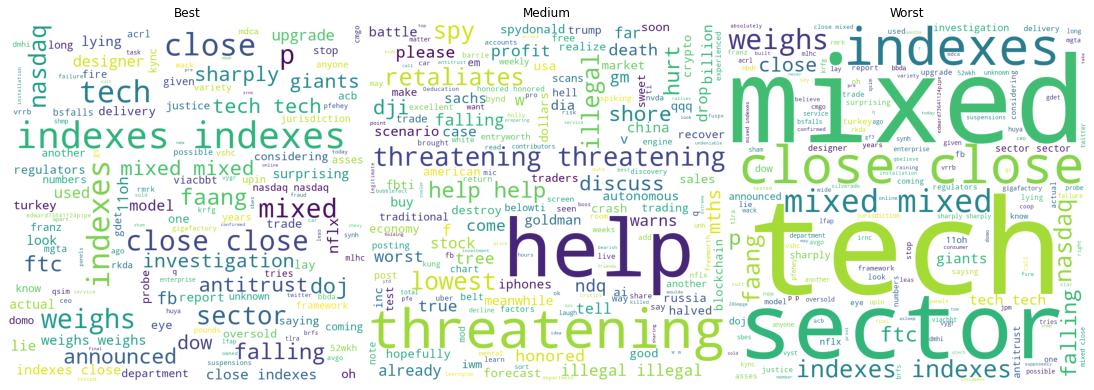

In [23]:
# plotting calculated wordclouds

plt.figure(figsize=(15,30))
plt.subplot(1,3,1)
plt.imshow(best_wordcloud)
plt.title("Best")
plt.axis("off")
plt.tight_layout(pad = 0)

plt.subplot(1,3,2)
plt.imshow(medium_wordcloud)
plt.title("Medium")
plt.axis("off")
plt.tight_layout(pad = 0)

plt.subplot(1,3,3)
plt.imshow(worst_wordcloud)
plt.title("Worst")
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

<li> We can see there is a difference of words with all three categories. Best predictions had illegal, threatening, battle words least frequent. </li>
<li> While for medium category indexes, weighs, mixed,close these words were least frequent. </li>
<li> Worst category least frequent words were tech, sector, weighs,ftc,falling etc. </li>

### 1.4 Plotting Feature Matrix as Images

#### With all the features available, one matrix was created to represent tweets for all day. Let us consider that feature matrix as an image and visualize those. It will not be possible to visualize all the feature matrices in three categories. Hence let us get first 10 visualizations.

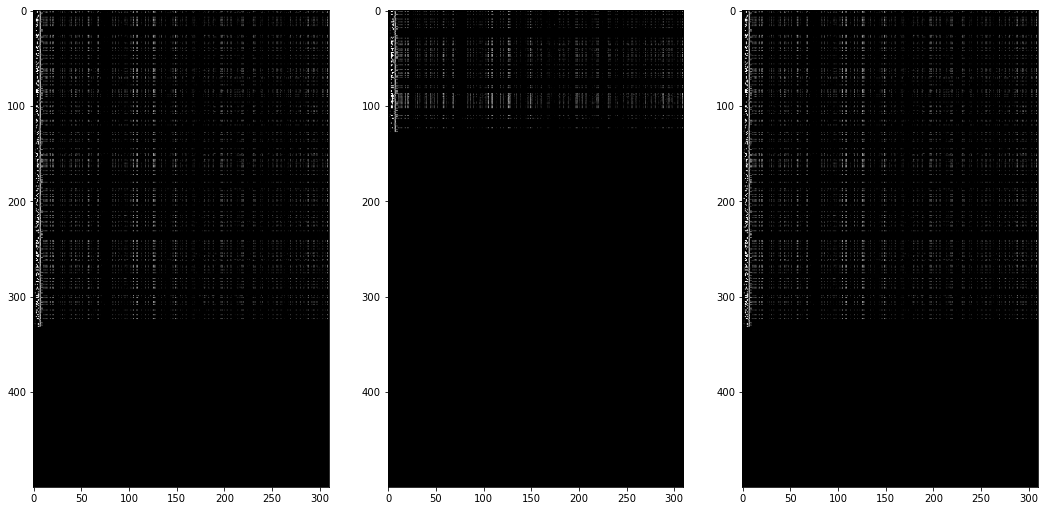

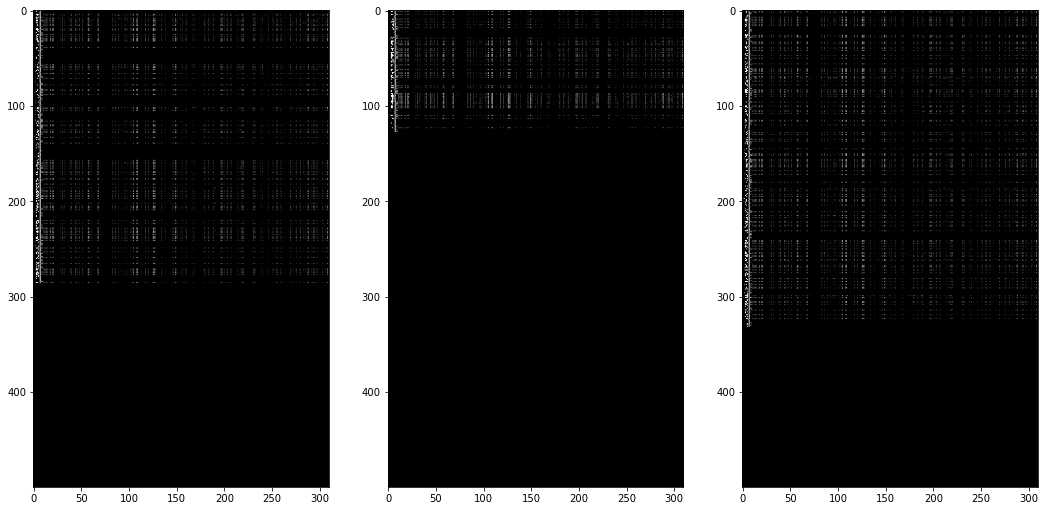

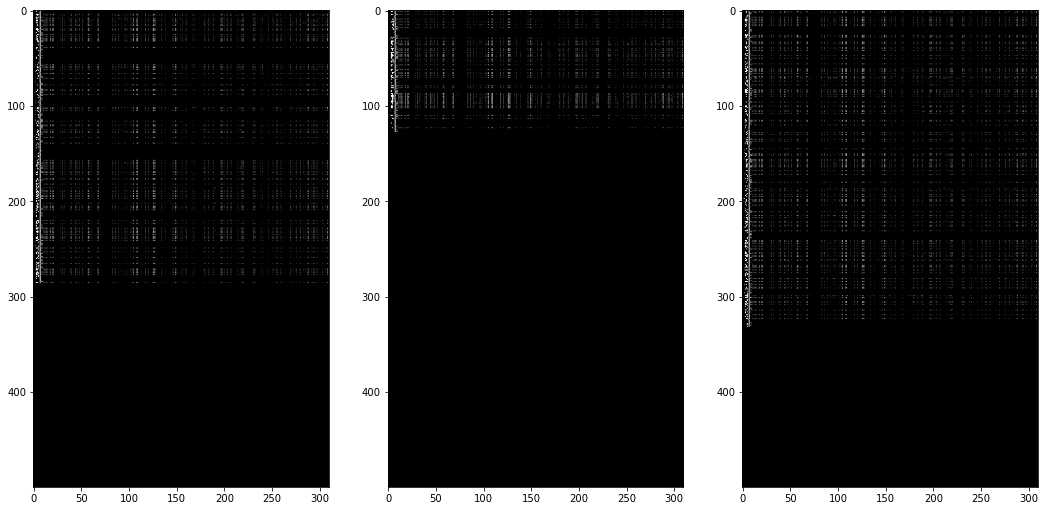

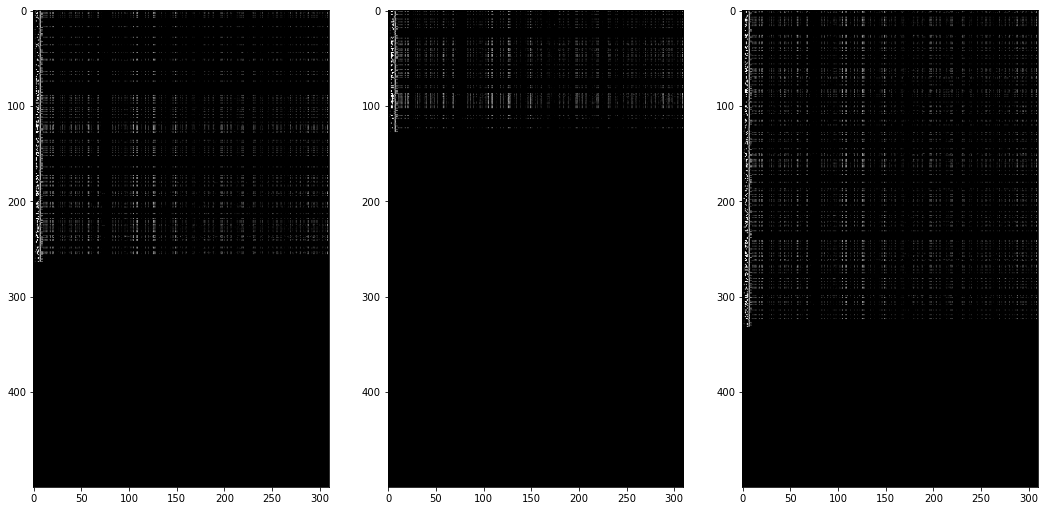

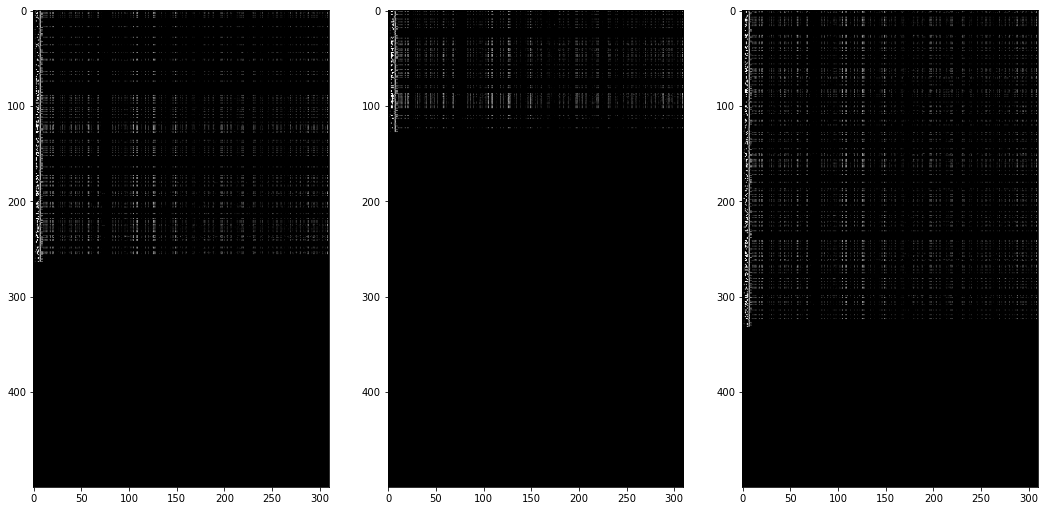

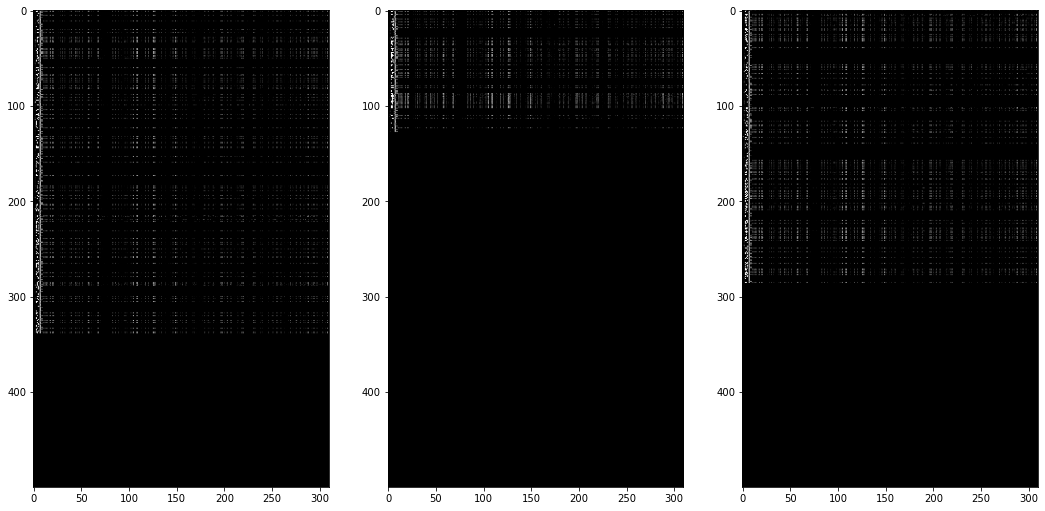

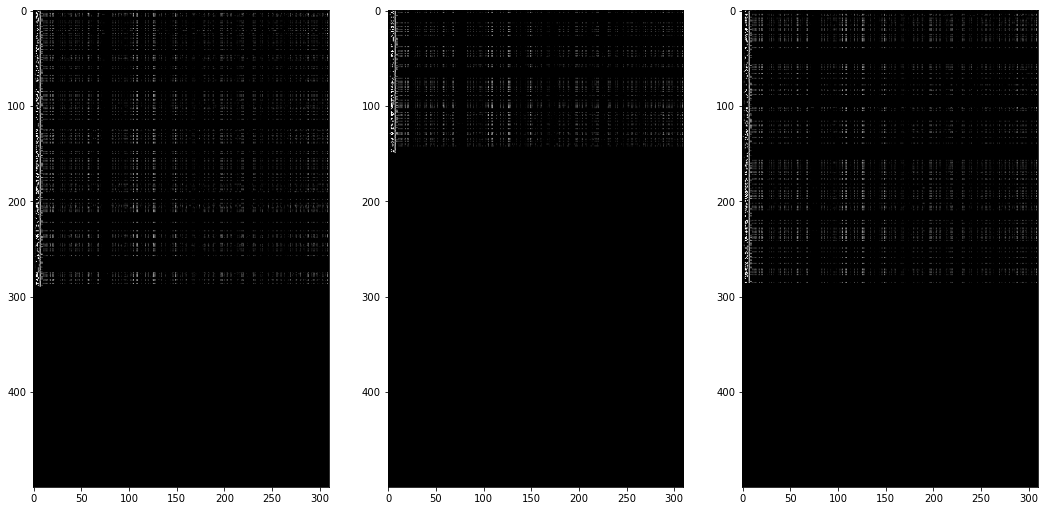

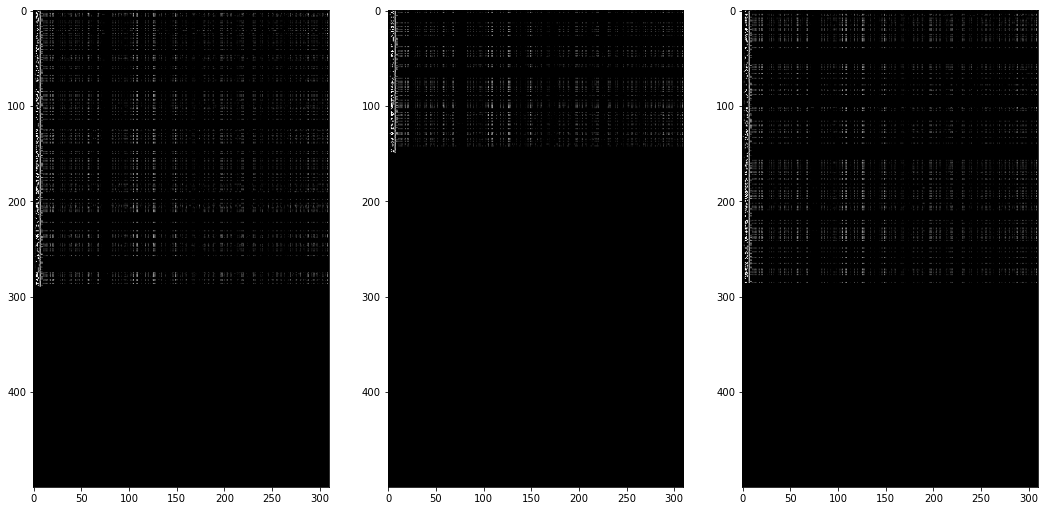

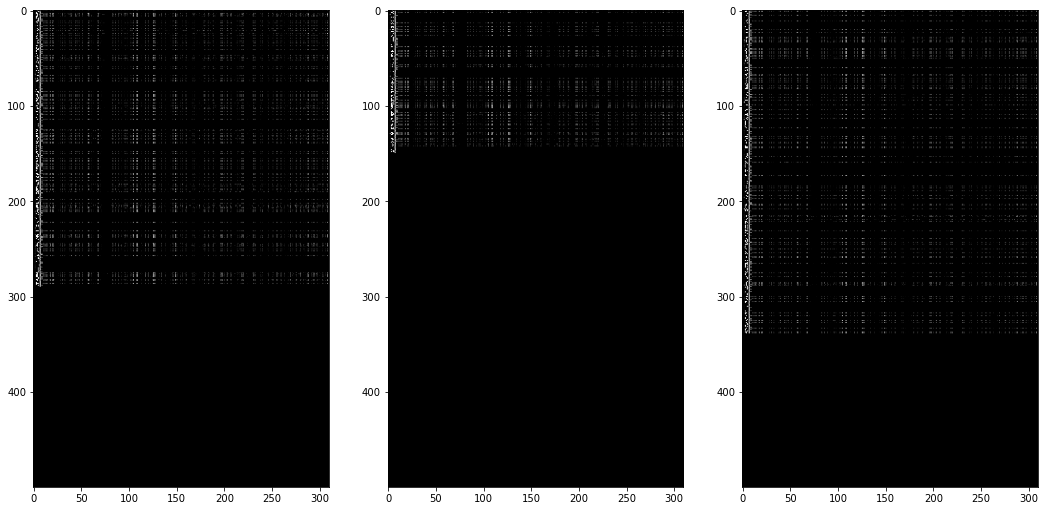

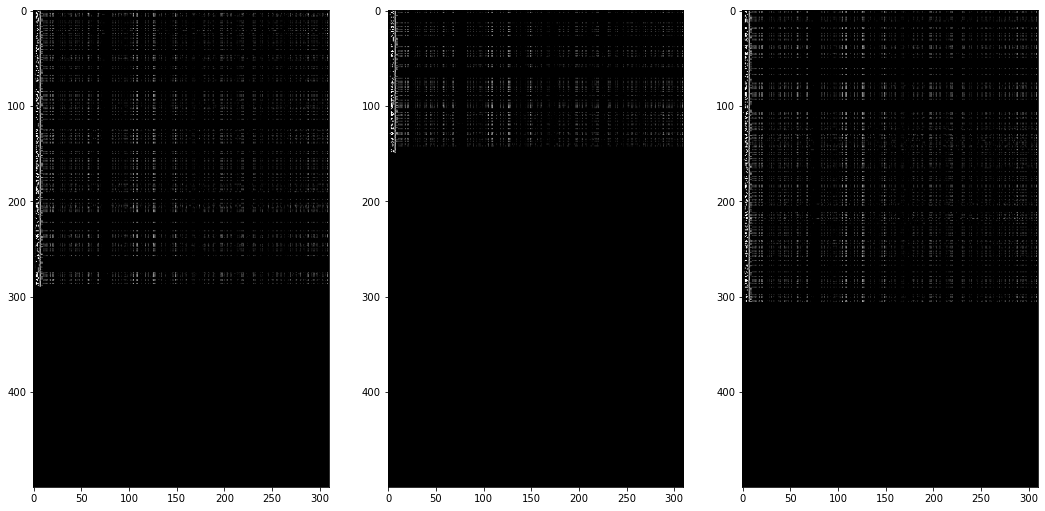

In [24]:
for i,j,k,l in zip(best_indices,medium_indices,worst_indices,range(10)):
    plt.figure(figsize=(18,24))
    plt.subplot(131)
    plt.imshow(test_data.iloc[i]['feat_mat'],cmap='gray',vmax=1,vmin=0)
    plt.subplot(132)
    plt.imshow(test_data.iloc[j]['feat_mat'],cmap='gray',vmax=1,vmin=0)
    plt.subplot(133)
    plt.imshow(test_data.iloc[k]['feat_mat'],cmap='gray',vmax=1,vmin=0)
    plt.show()
    if l==9:
        break

#### The matrix was padded with zeros to make the dimensions equal for all days. Hence, the black portion here is padded region.

<li> We can observe a trend here that, for best predictions, padded region is more. That means with lesser number of tweets per day, predictions were best. </li>
<li> While worst predictions, the padded region is lowest in these three categories. Hence worst predictions are obtained if number of tweets are more in a day. </li>

### 1.5 Negative word count Histogram

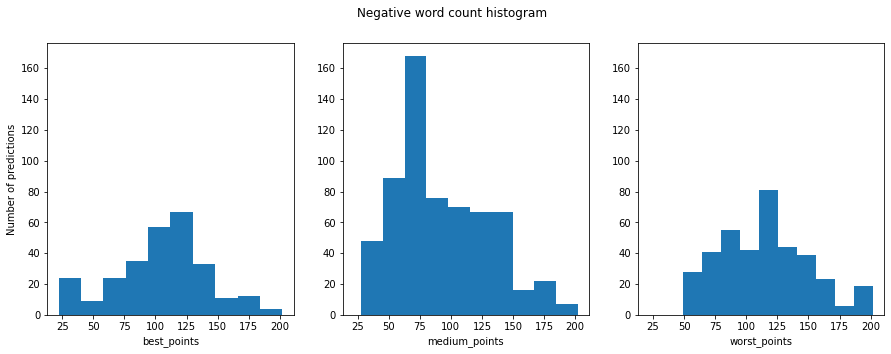

In [25]:
fig = plt.figure(figsize=(15,5))
fig.suptitle("Negative word count histogram")
ax1 = fig.add_subplot(1,3,1)
ax1.hist(best_neg_count)
plt.xlabel("best_points")
plt.ylabel("Number of predictions")


ax2 = fig.add_subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2.hist(medium_neg_count)
plt.xlabel("medium_points")


ax3 = fig.add_subplot(1,3,3, sharex=ax1, sharey=ax1)
ax3.hist(worst_neg_count)
plt.xlabel("worst_points")

plt.show()

<li> We can observe if negative sentiment words are of lesser in number then we are getting best predictions while if those are higher then we are getting worst predictions. </li>

### 1.6 Positive word count Histogram

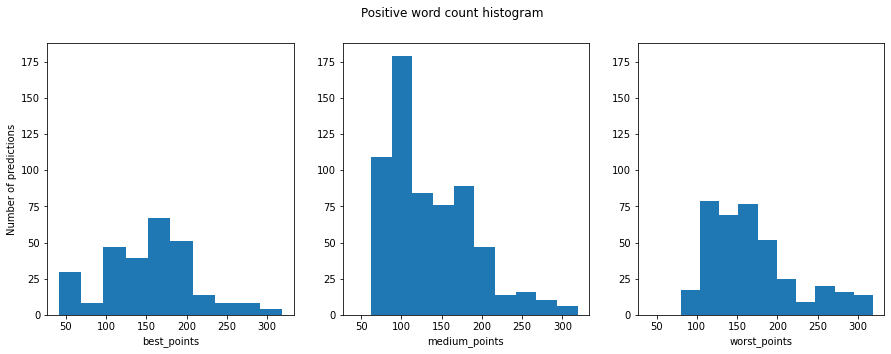

In [26]:
fig = plt.figure(figsize=(15,5))
fig.suptitle("Positive word count histogram")
ax1 = fig.add_subplot(1,3,1)
ax1.hist(best_pos_count)
plt.xlabel("best_points")
plt.ylabel("Number of predictions")


ax2 = fig.add_subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2.hist(medium_pos_count)
plt.xlabel("medium_points")


ax3 = fig.add_subplot(1,3,3, sharex=ax1, sharey=ax1)
ax3.hist(worst_pos_count)
plt.xlabel("worst_points")

plt.show()

<li> Similary, We can observe if positive sentiment words are of lesser in number then we are getting best predictions while if that number gets higher then we are getting worst predictions. </li>

### 1.7 Neutral word count Histogram

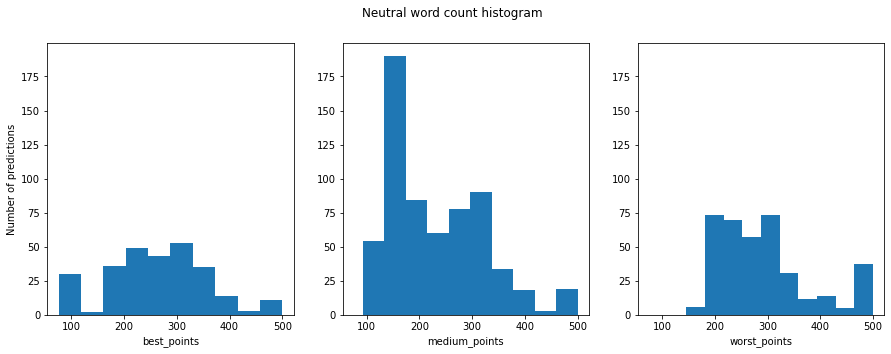

In [27]:
fig = plt.figure(figsize=(15,5))
fig.suptitle("Neutral word count histogram")
ax1 = fig.add_subplot(1,3,1)
ax1.hist(best_neu_count)
plt.xlabel("best_points")
plt.ylabel("Number of predictions")


ax2 = fig.add_subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2.hist(medium_neu_count)
plt.xlabel("medium_points")


ax3 = fig.add_subplot(1,3,3, sharex=ax1, sharey=ax1)
ax3.hist(worst_neu_count)
plt.xlabel("worst_points")

plt.show()

<li> Similar but lesser when compared to positive or negative sentiment, can be observed with neutral words. </li>

### 1.8 URL Flag count Histogram

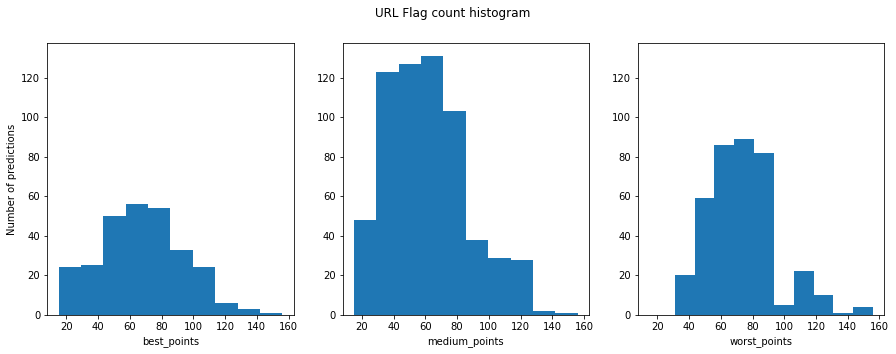

In [28]:
fig = plt.figure(figsize=(15,5))
fig.suptitle("URL Flag count histogram")
ax1 = fig.add_subplot(1,3,1)
ax1.hist(best_URL_flag)
plt.xlabel("best_points")
plt.ylabel("Number of predictions")


ax2 = fig.add_subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2.hist(medium_URL_flag)
plt.xlabel("medium_points")


ax3 = fig.add_subplot(1,3,3, sharex=ax1, sharey=ax1)
ax3.hist(worst_URL_flag)
plt.xlabel("worst_points")

plt.show()

<li> We can observe that with lesser number of URLs in tweets, we are getting best predictions. </li>

### 1.9 Hashtag Flag count Histogram

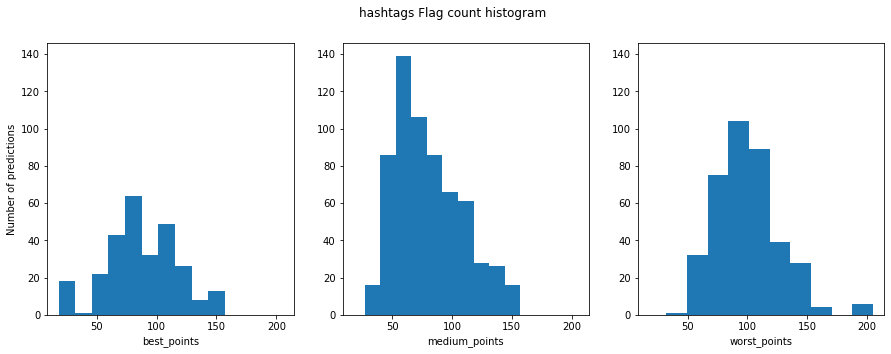

In [29]:
fig = plt.figure(figsize=(15,5))
fig.suptitle("hashtags Flag count histogram")
ax1 = fig.add_subplot(1,3,1)
ax1.hist(best_hashtags_flag)
plt.xlabel("best_points")
plt.ylabel("Number of predictions")


ax2 = fig.add_subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2.hist(medium_hashtags_flag)
plt.xlabel("medium_points")


ax3 = fig.add_subplot(1,3,3, sharex=ax1, sharey=ax1)
ax3.hist(worst_hashtags_flag)
plt.xlabel("worst_points")

plt.show()

<li> Similar trend can be observed with hashtag flag. </li>

### 1.10 Mention Flag count Histogram

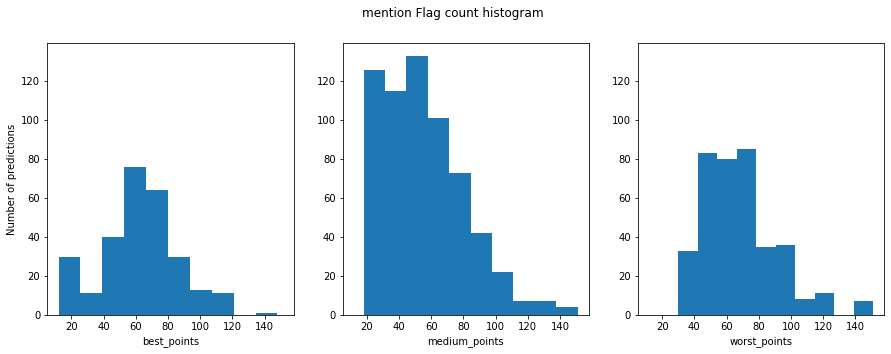

In [30]:
fig = plt.figure(figsize=(15,5))
fig.suptitle("mention Flag count histogram")
ax1 = fig.add_subplot(1,3,1)
ax1.hist(best_mention_flag)
plt.xlabel("best_points")
plt.ylabel("Number of predictions")


ax2 = fig.add_subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2.hist(medium_mention_flag)
plt.xlabel("medium_points")


ax3 = fig.add_subplot(1,3,3, sharex=ax1, sharey=ax1)
ax3.hist(worst_mention_flag)
plt.xlabel("worst_points")

plt.show()

<li> Similar trend can be observed with mention flag. </li>

# 2. sign_change prediction

<li> Sign change prediction is a binary variable and takes values 0 & 1. </li>
<li> Sigmoid activation was used for output layer of this prediction hence the output will be in in form as probability score.</li>
<li> Based on this probability score, the points were classified in three categories as follows </li>

<table>
    <tr> 
        <td><b>Category</b></td>
        <td><b>Output Score</b></td>
    </tr>
    <tr>
        <td> Best </td>
        <td> <li> y_true = 0 and score <= 0.30 </li>
             <li> y_true = 1 and score >= 0.70  </li> </td>
    </tr>
    <tr>
        <td> Medium </td>
        <td> <li> y_true = 0 and 0.3 < score <= 0.45 </li>
             <li> y_true = 1 and 0.55 <= score < 0.70  </li> </td>
    </tr>
    <tr>
        <td> Worst </td>
        <td> 0.45 < score < 0.55 </td>
    </tr>
</table>

<li> It is assumed that the probability scores between 0.45 and 0.55 give random output and it is difficult to conclude from these scores. </li>

In [25]:
best_indices = []  # empty list to store best prediction indices in test data
medium_indices = []  # empty list to store medium prediction indices in test data
worst_indices = []  # empty list to store worst prediction indices in test data

for i in range(len(y_test_sign)):
    if ((y_test_sign[i] == 0 and prediction[1][i] <= 0.3) 
    or (y_test_sign[i] == 1 and prediction[1][i] >= 0.7)):
        best_indices.append(i)
    elif ((y_test_sign[i] == 0 and prediction[1][i] > 0.3 and prediction[1][i] <= 0.45)
    or (y_test_sign[i] == 1 and prediction[1][i] >= 0.55 and prediction[1][i] < 0.7)):
        medium_indices.append(i)
    else:
        worst_indices.append(i)
        
best_indices = np.array(best_indices)
medium_indices = np.array(medium_indices)
worst_indices = np.array(worst_indices)

### 2.1 Getting Word and Feature frequencies

#### 2.1.1 Best predictions

In [26]:
# Referred wordcloud from here : https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


# function to count word occurances
def count_words(str):
    word_count = dict()
    words = str.split()

    for word in tqdm(words):
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1

    return word_count

words = ''
stopwords = set(STOPWORDS)

# empty lists to store feature related information
best_neg_count = []
best_neu_count = []
best_pos_count = []
best_URL_flag = []
best_hashtags_flag = []
best_mention_flag = []

for i in tqdm(best_indices):
    best_neg_count.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,6]))
    best_neu_count.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,7]))
    best_pos_count.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,8]))
    best_URL_flag.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,3]))
    best_hashtags_flag.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,4]))
    best_mention_flag.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,5]))
    temp = test_data.iloc[i]['tweet_text']
    temp = temp.replace('aapl','')
    temp = temp.replace('amzn','')
    temp = temp.replace('tsla','')
    temp = temp.replace('googl','')
    temp = temp.replace('goog','')
    temp = temp.replace('msft','')
    temp = temp.replace('apple','')
    temp = temp.replace('amazon','')
    temp = temp.replace('tesla','')
    temp = temp.replace('google','')
    temp = temp.replace('microsoft','')
    words += " "+temp+" "   # Getting all words from test essay data to create wordcloud

word_count = count_words(words)

best_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)

best_words = np.array(list(word_count.keys()))
best_count = np.array(list(word_count.values()))

best_ind = np.argsort(best_count)

print("Top 10 words for best prediction are : \n\n")

for i in range(-1,-11,-1):
    print("word : ",best_words[best_ind[i]],"      ","Count : ",best_count[best_ind[i]])
    
    
print("\n\nTop 10 rare words for best prediction are : \n\n")

for i in range(11):
    print("word : ",best_words[best_ind[i]],"      ","Count : ",best_count[best_ind[i]])

100%|███████████████████████████████████████████████████████████████████| 1322968/1322968 [00:00<00:00, 2737247.99it/s]


Top 10 words for best prediction are : 


word :  fb        Count :  15344
word :  nflx        Count :  10992
word :  spy        Count :  9997
word :  not        Count :  9406
word :  1        Count :  7073
word :  qqq        Count :  6990
word :  3        Count :  6812
word :  amd        Count :  6726
word :  nvda        Count :  6047
word :  q        Count :  5466


Top 10 rare words for best prediction are : 


word :  ichimoku        Count :  3
word :  earphones        Count :  3
word :  lulu81        Count :  3
word :  ziop82        Count :  3
word :  nvcr84        Count :  3
word :  snap85        Count :  3
word :  mrk86        Count :  3
word :  abt87        Count :  3
word :  arwr90        Count :  3
word :  zts95        Count :  3
word :  57agree        Count :  3


#### 2.1.2 Medium Predictions

In [27]:
words = ''
stopwords = set(STOPWORDS)

medium_neg_count = []
medium_neu_count = []
medium_pos_count = []
medium_URL_flag = []
medium_hashtags_flag = []
medium_mention_flag = []

for i in tqdm(medium_indices):
    medium_neg_count.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,6]))
    medium_neu_count.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,7]))
    medium_pos_count.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,8]))
    medium_URL_flag.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,3]))
    medium_hashtags_flag.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,4]))
    medium_mention_flag.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,5]))
    temp = test_data.iloc[i]['tweet_text']
    temp = temp.replace('aapl','')
    temp = temp.replace('amzn','')
    temp = temp.replace('tsla','')
    temp = temp.replace('googl','')
    temp = temp.replace('goog','')
    temp = temp.replace('msft','')
    temp = temp.replace('apple','')
    temp = temp.replace('amazon','')
    temp = temp.replace('tesla','')
    temp = temp.replace('google','')
    temp = temp.replace('microsoft','')
    words += " "+temp+" "   # Getting all words from test essay data to create wordcloud

word_count = count_words(words)


medium_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)

medium_words = np.array(list(word_count.keys()))
medium_count = np.array(list(word_count.values()))

medium_ind = np.argsort(medium_count)

print("Top 10 words for medium prediction are : \n\n")

for i in range(-1,-11,-1):
    print("word : ",medium_words[medium_ind[i]],"      ","Count : ",medium_count[medium_ind[i]])
    
    
print("\n\nTop 10 rare words for medium prediction are : \n\n")

for i in range(10):
    print("word : ",medium_words[medium_ind[i]],"      ","Count : ",medium_count[medium_ind[i]])

100%|███████████████████████████████████████████████████████████████████| 2056705/2056705 [00:00<00:00, 2732548.75it/s]


Top 10 words for medium prediction are : 


word :  fb        Count :  20744
word :  nflx        Count :  14446
word :  not        Count :  13893
word :  spy        Count :  11600
word :  1        Count :  10497
word :  3        Count :  9230
word :  amd        Count :  8732
word :  qqq        Count :  8252
word :  q        Count :  7905
word :  nvda        Count :  7863


Top 10 rare words for medium prediction are : 


word :  approvalgood        Count :  1
word :  winningstock        Count :  1
word :  wcxcycc        Count :  1
word :  z15        Count :  1
word :  myths4        Count :  1
word :  kirin        Count :  1
word :  ops2        Count :  1
word :  expectedalso1        Count :  1
word :  cloudy        Count :  1
word :  soonweek        Count :  1


#### 2.1.3 Worst Predictions

In [28]:
words = ''
stopwords = set(STOPWORDS)

worst_neg_count = []
worst_neu_count = []
worst_pos_count = []
worst_URL_flag = []
worst_hashtags_flag = []
worst_mention_flag = []

for i in tqdm(worst_indices):
    worst_neg_count.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,6]))
    worst_neu_count.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,7]))
    worst_pos_count.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,8]))
    worst_URL_flag.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,3]))
    worst_hashtags_flag.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,4]))
    worst_mention_flag.append(np.count_nonzero(test_data.iloc[i]['feat_mat'][:,5]))
    temp = test_data.iloc[i]['tweet_text']
    temp = temp.replace('aapl','')
    temp = temp.replace('amzn','')
    temp = temp.replace('tsla','')
    temp = temp.replace('googl','')
    temp = temp.replace('goog','')
    temp = temp.replace('msft','')
    temp = temp.replace('apple','')
    temp = temp.replace('amazon','')
    temp = temp.replace('tesla','')
    temp = temp.replace('google','')
    temp = temp.replace('microsoft','')
    words += " "+temp+" "   # Getting all words from test essay data to create wordcloud

word_count = count_words(words)


worst_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)

worst_words = np.array(list(word_count.keys()))
worst_count = np.array(list(word_count.values()))

worst_ind = np.argsort(worst_count)

print("Top 10 words for worst prediction  are : \n\n")

for i in range(-1,-11,-1):
    print("word : ",worst_words[worst_ind[i]],"      ","Count : ",worst_count[worst_ind[i]])
    
    
print("\n\nTop 10 rare words for worst prediction are : \n\n")

for i in range(10):
    print("word : ",worst_words[worst_ind[i]],"      ","Count : ",worst_count[worst_ind[i]])

100%|███████████████████████████████████████████████████████████████████| 2289203/2289203 [00:00<00:00, 2764674.80it/s]


Top 10 words for worst prediction  are : 


word :  fb        Count :  21021
word :  not        Count :  15621
word :  nflx        Count :  14640
word :  spy        Count :  12266
word :  1        Count :  11700
word :  3        Count :  10281
word :  amd        Count :  9389
word :  q        Count :  8878
word :  qqq        Count :  8238
word :  nvda        Count :  8009


Top 10 rare words for worst prediction are : 


word :  radarsdisruptive        Count :  1
word :  foolimagine        Count :  1
word :  000daughter        Count :  1
word :  gymnastics        Count :  1
word :  medals        Count :  1
word :  admitweek        Count :  1
word :  cornerered        Count :  1
word :  zippy        Count :  1
word :  4wd        Count :  1
word :  corvette        Count :  1


<li> We can observe words fb,nflx,spy,not,1  made it to top 5 in all categories </li>
<li> While least frequent words can not be judged with just 10 words, since there will be many words with count 1 hence let us analyze those with wordcloud. </li>

### 2.2 Plotting wordcloud for Most Frequent Words

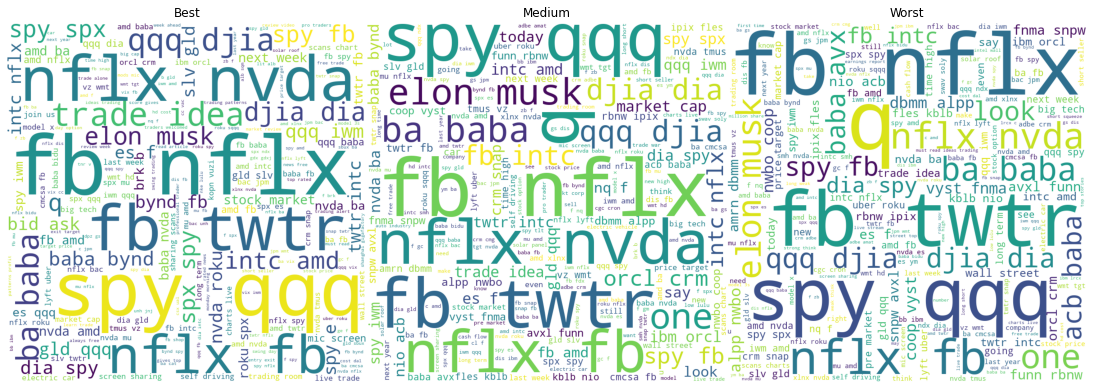

In [29]:
plt.figure(figsize=(15,30))
plt.subplot(1,3,1)
plt.imshow(best_wordcloud)
plt.title("Best")
plt.axis("off")
plt.tight_layout(pad = 0)

plt.subplot(1,3,2)
plt.imshow(medium_wordcloud)
plt.title("Medium")
plt.axis("off")
plt.tight_layout(pad = 0)

plt.subplot(1,3,3)
plt.imshow(worst_wordcloud)
plt.title("Worst")
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

<li> With this wordcloud, we can observe there are many words common most frequent words for all three categories. </li>

### 2.3 Plotting wordcloud for Most Rare Words

In [30]:
# least occuring 10000 words are considered as rare words here
# getting Least occuring 10000 words and creating wordcloud from those


words = ''
for i in best_count[:10000]:
    words += " "+best_words[i]+" "

best_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)

words = ''
for i in medium_count[:10000]:
    words += " "+medium_words[i]+" "

medium_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)

words = ''
for i in worst_count[:10000]:
    words += " "+worst_words[i]+" "

worst_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)

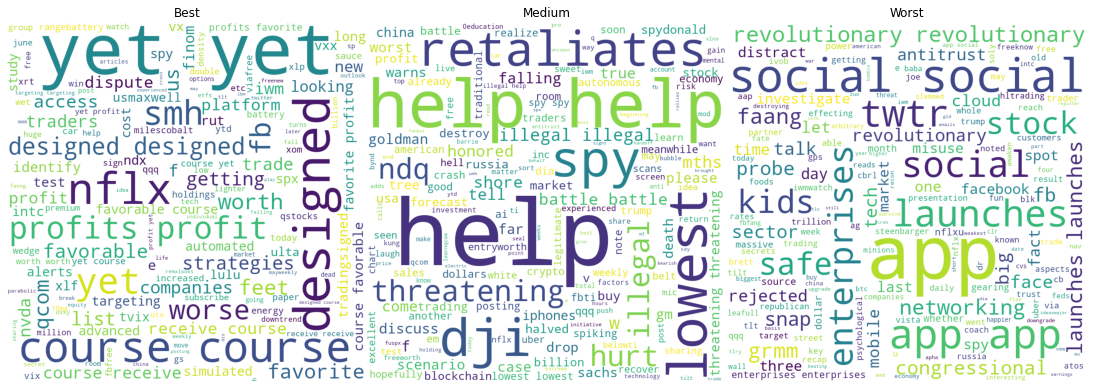

In [31]:
# plotting calculated wordclouds

plt.figure(figsize=(15,30))
plt.subplot(1,3,1)
plt.imshow(best_wordcloud)
plt.title("Best")
plt.axis("off")
plt.tight_layout(pad = 0)

plt.subplot(1,3,2)
plt.imshow(medium_wordcloud)
plt.title("Medium")
plt.axis("off")
plt.tight_layout(pad = 0)

plt.subplot(1,3,3)
plt.imshow(worst_wordcloud)
plt.title("Worst")
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

<li> We can see there is a difference of words with all three categories. Best predictions had designed, nflx, yet,course words least frequent. </li>
<li> While for medium category help, spy, lowest,retaliates these words were least frequent. </li>
<li> Worst category least frequent words were social, stock,app,enterprises,launches etc. </li>

### 2.4 Plotting Feature Matrix as Images

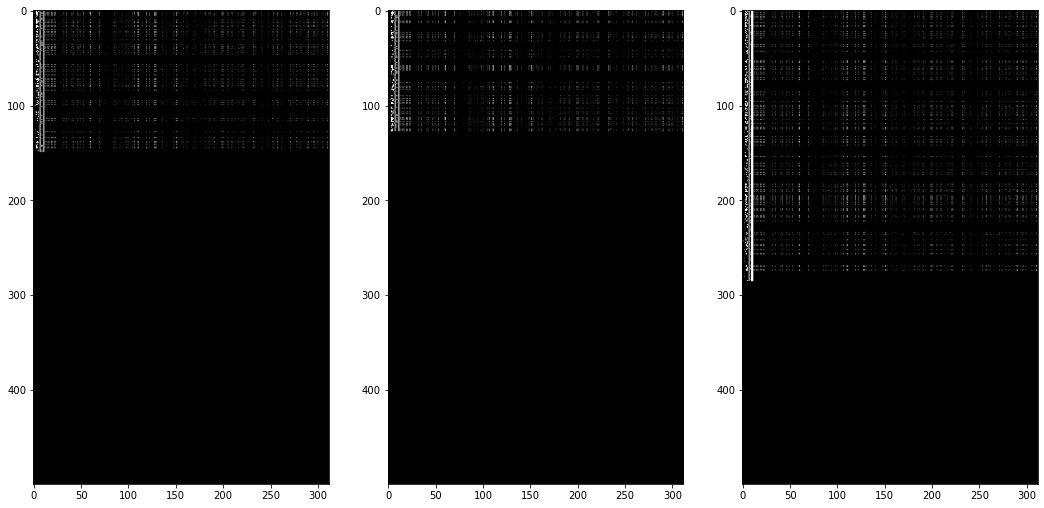

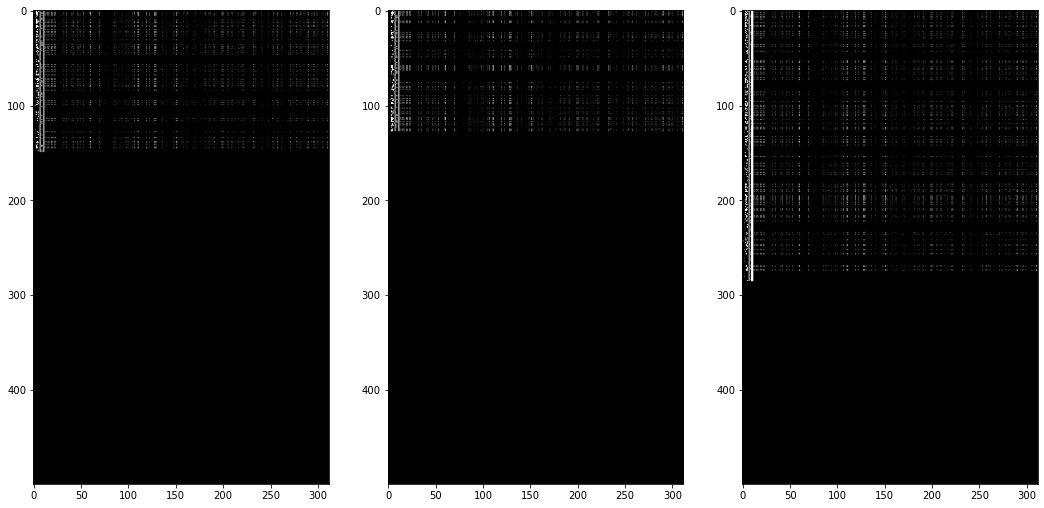

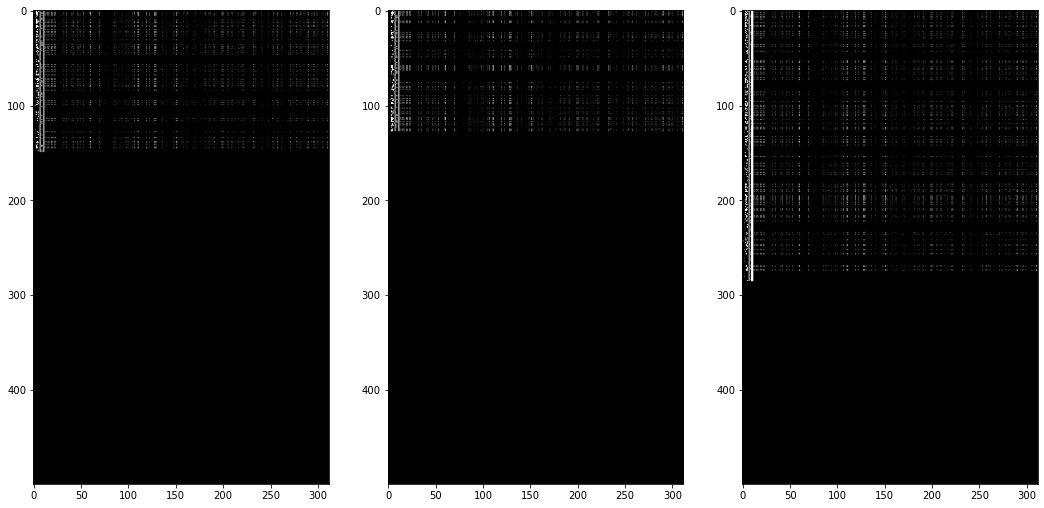

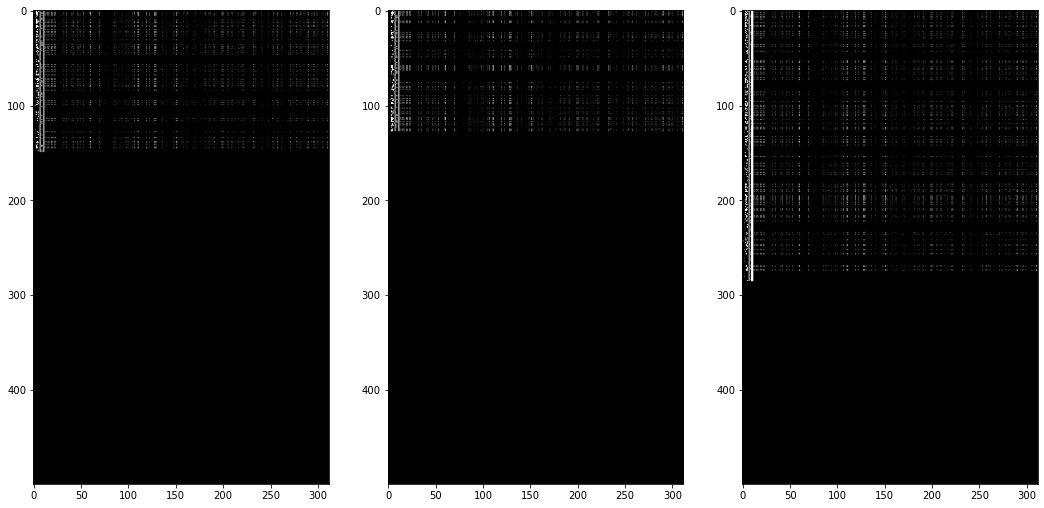

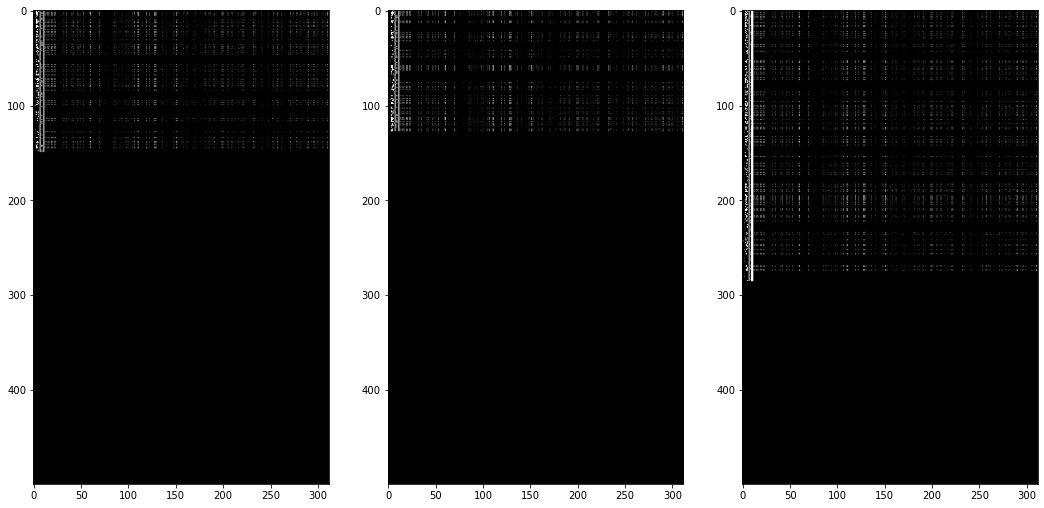

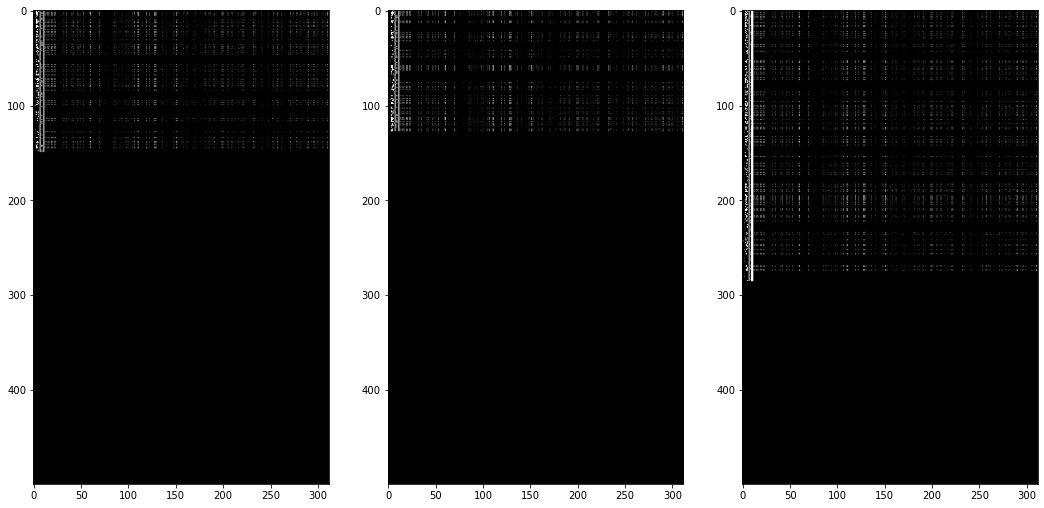

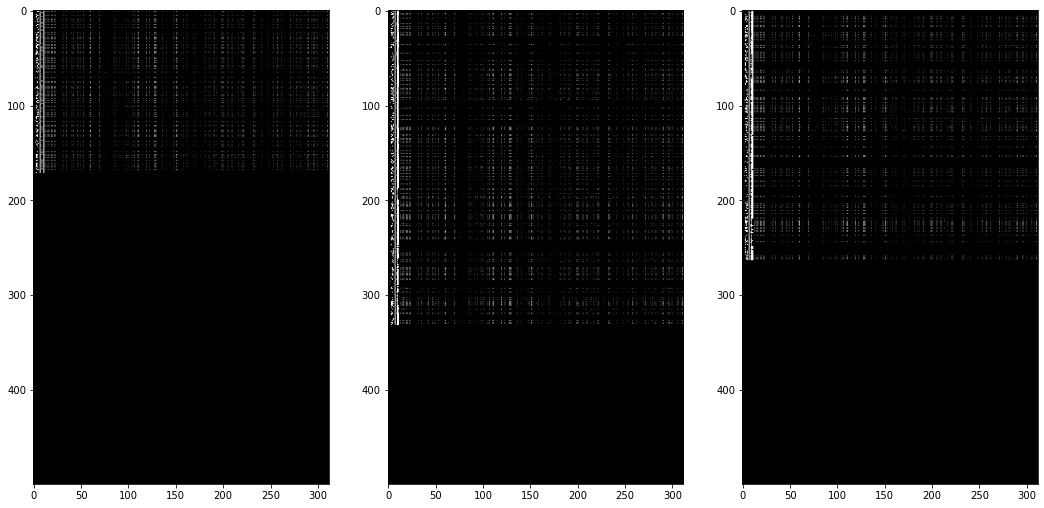

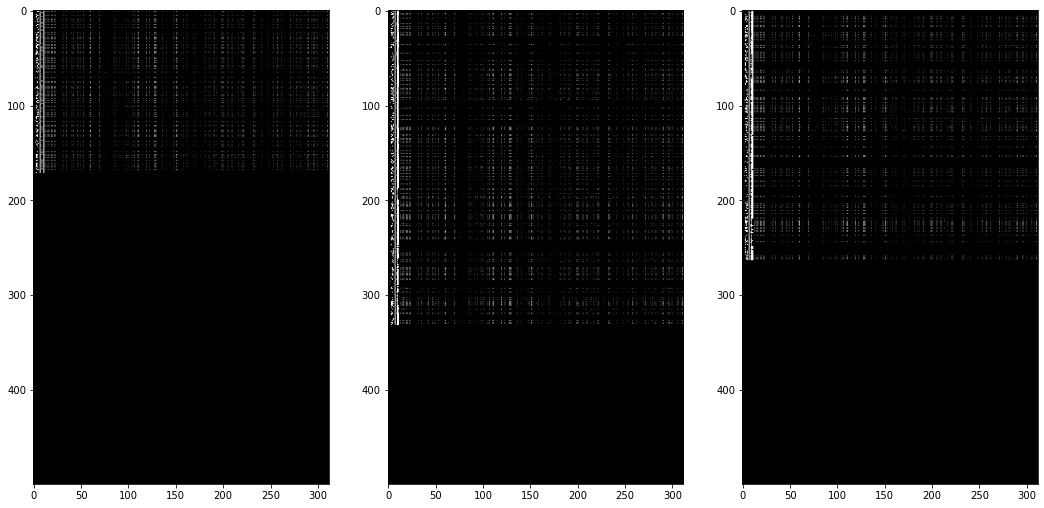

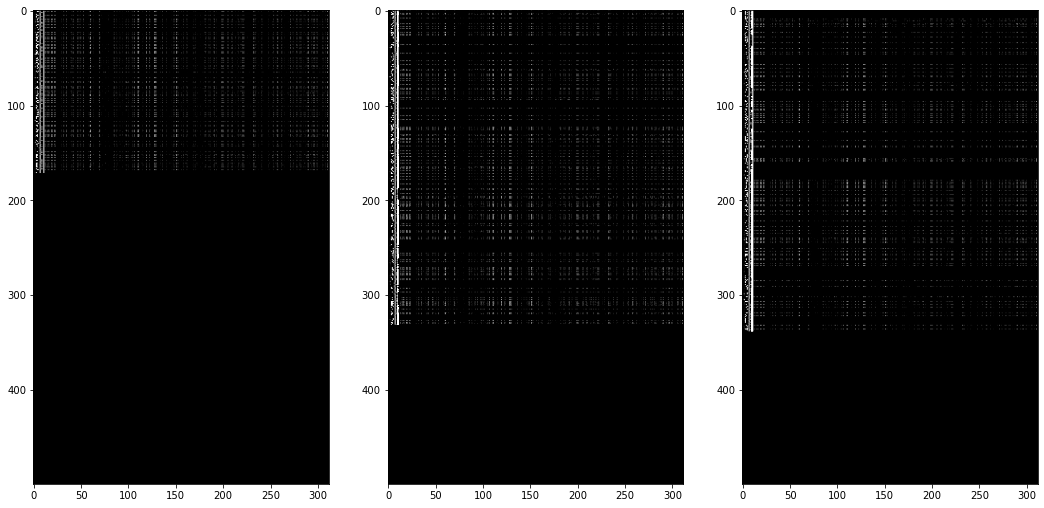

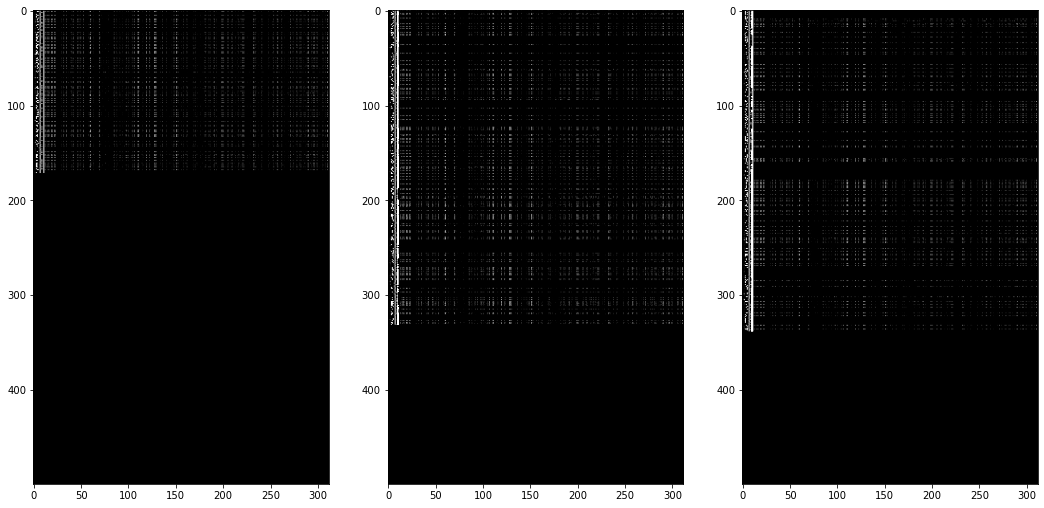

In [32]:
for i,j,k,l in zip(best_indices,medium_indices,worst_indices,range(10)):
    plt.figure(figsize=(18,24))
    plt.subplot(131)
    plt.imshow(test_data.iloc[i]['feat_mat'],cmap='gray',vmax=1,vmin=0)
    plt.subplot(132)
    plt.imshow(test_data.iloc[j]['feat_mat'],cmap='gray',vmax=1,vmin=0)
    plt.subplot(133)
    plt.imshow(test_data.iloc[k]['feat_mat'],cmap='gray',vmax=1,vmin=0)
    plt.show()
    if l==9:
        break

#### The matrix was padded with zeros to make the dimension equal for all days. Hence, the black portion here is padded region.

<li> We can observe a trend here that, for best predictions, padded region is more. That means with lesser number of tweets per day, predictions were best. </li>
<li> Unlike change predictions, for some sign predictions in medium category, the padded region is also lesser that means the predictions are in medium category even if number of tweets are more. </li>

### 2.5 Negative word count Histogram

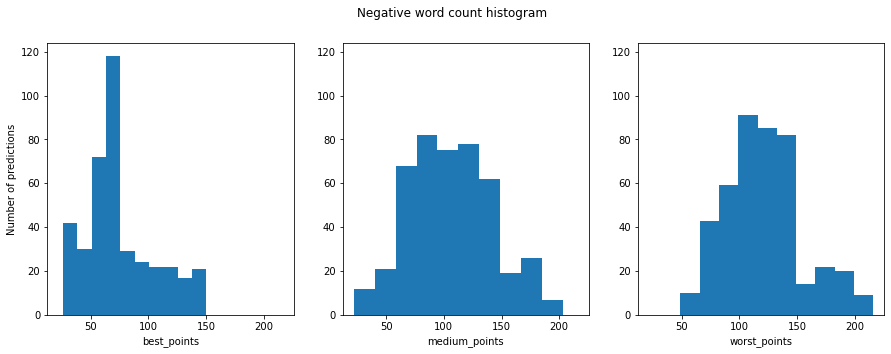

In [33]:
fig = plt.figure(figsize=(15,5))
fig.suptitle("Negative word count histogram")
ax1 = fig.add_subplot(1,3,1)
ax1.hist(best_neg_count)
plt.xlabel("best_points")
plt.ylabel("Number of predictions")


ax2 = fig.add_subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2.hist(medium_neg_count)
plt.xlabel("medium_points")


ax3 = fig.add_subplot(1,3,3, sharex=ax1, sharey=ax1)
ax3.hist(worst_neg_count)
plt.xlabel("worst_points")

plt.show()

<li> We can observe if negative sentiment words are lesser in number then we are getting best predictions while if those are higher then we are getting worst predictions. </li>

### 2.6 Positive word count Histogram

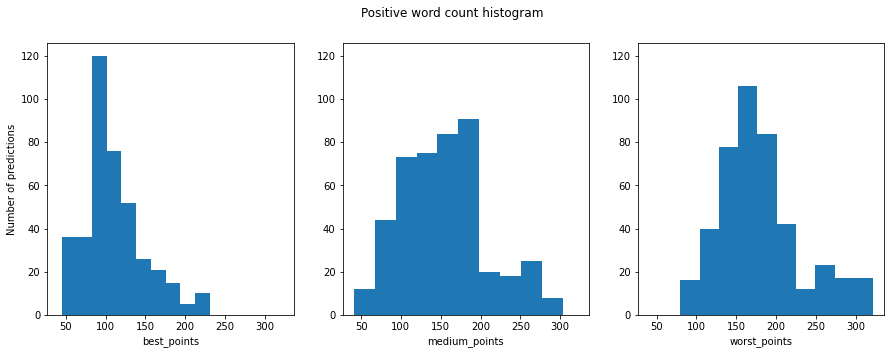

In [34]:
fig = plt.figure(figsize=(15,5))
fig.suptitle("Positive word count histogram")
ax1 = fig.add_subplot(1,3,1)
ax1.hist(best_pos_count)
plt.xlabel("best_points")
plt.ylabel("Number of predictions")


ax2 = fig.add_subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2.hist(medium_pos_count)
plt.xlabel("medium_points")


ax3 = fig.add_subplot(1,3,3, sharex=ax1, sharey=ax1)
ax3.hist(worst_pos_count)
plt.xlabel("worst_points")

plt.show()

<li> Similary, We can observe if positive sentiment words are lesser in number then we are getting best predictions while if that number gets higher then we are getting worst predictions. </li>

### 2.7 Neutral word count Histogram

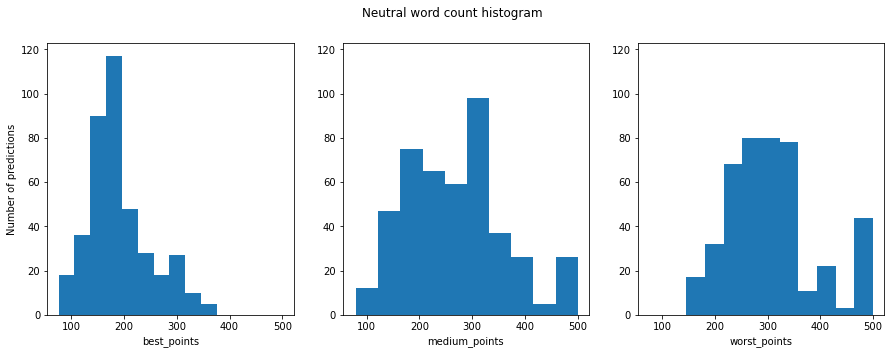

In [35]:
fig = plt.figure(figsize=(15,5))
fig.suptitle("Neutral word count histogram")
ax1 = fig.add_subplot(1,3,1)
ax1.hist(best_neu_count)
plt.xlabel("best_points")
plt.ylabel("Number of predictions")


ax2 = fig.add_subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2.hist(medium_neu_count)
plt.xlabel("medium_points")


ax3 = fig.add_subplot(1,3,3, sharex=ax1, sharey=ax1)
ax3.hist(worst_neu_count)
plt.xlabel("worst_points")

plt.show()

<li> Similar but lesser when compared to positive or negative sentiment, can be observed with neutral words. </li>

### 2.8 URL Flag count Histogram

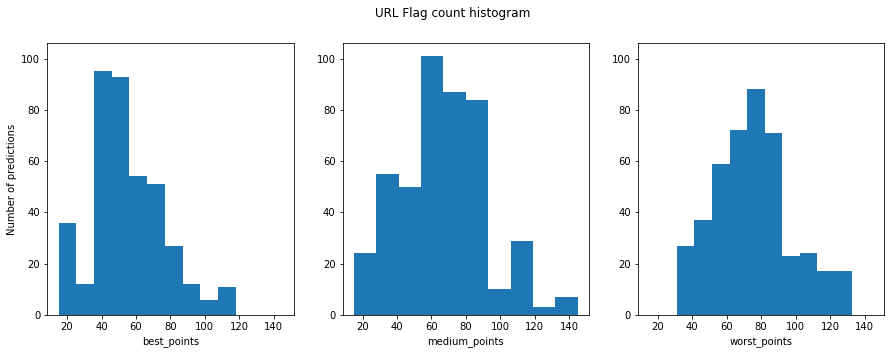

In [36]:
fig = plt.figure(figsize=(15,5))
fig.suptitle("URL Flag count histogram")
ax1 = fig.add_subplot(1,3,1)
ax1.hist(best_URL_flag)
plt.xlabel("best_points")
plt.ylabel("Number of predictions")


ax2 = fig.add_subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2.hist(medium_URL_flag)
plt.xlabel("medium_points")


ax3 = fig.add_subplot(1,3,3, sharex=ax1, sharey=ax1)
ax3.hist(worst_URL_flag)
plt.xlabel("worst_points")

plt.show()

<li> We can observe that with lesser number of URLs in tweets, we are getting best predictions. </li>

### 2.9 Hashtag Flag count Histogram

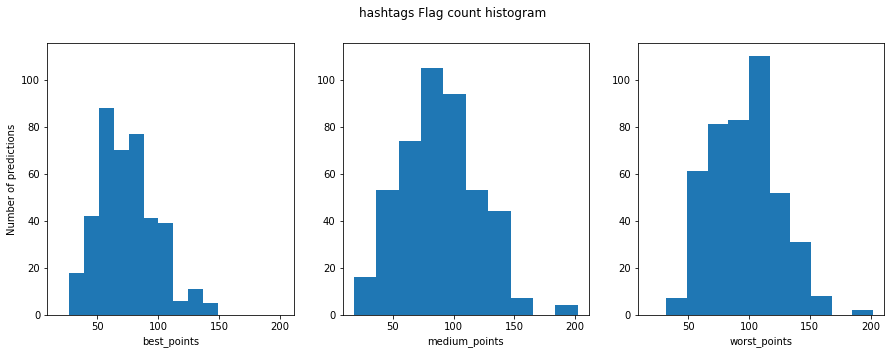

In [37]:
fig = plt.figure(figsize=(15,5))
fig.suptitle("hashtags Flag count histogram")
ax1 = fig.add_subplot(1,3,1)
ax1.hist(best_hashtags_flag)
plt.xlabel("best_points")
plt.ylabel("Number of predictions")


ax2 = fig.add_subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2.hist(medium_hashtags_flag)
plt.xlabel("medium_points")


ax3 = fig.add_subplot(1,3,3, sharex=ax1, sharey=ax1)
ax3.hist(worst_hashtags_flag)
plt.xlabel("worst_points")

plt.show()

<li> It is difficult to comment by observing this hashtag_flag histogram. </li>

### 2.10 Mention Flag count Histogram

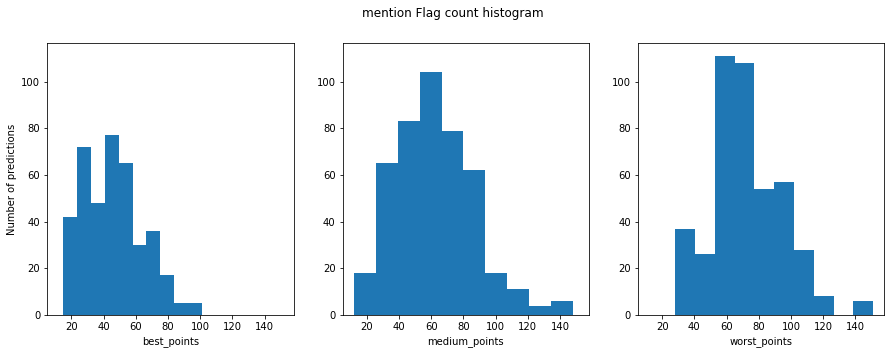

In [38]:
fig = plt.figure(figsize=(15,5))
fig.suptitle("mention Flag count histogram")
ax1 = fig.add_subplot(1,3,1)
ax1.hist(best_mention_flag)
plt.xlabel("best_points")
plt.ylabel("Number of predictions")


ax2 = fig.add_subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2.hist(medium_mention_flag)
plt.xlabel("medium_points")


ax3 = fig.add_subplot(1,3,3, sharex=ax1, sharey=ax1)
ax3.hist(worst_mention_flag)
plt.xlabel("worst_points")

plt.show()

<li> Although there is a trend of geeting best to medium predictions if mention_flag count is lower but it is difficult to comment with little high number. </li>

# Conclusion and Observations

### 1. % change prediction

<li> With the word frequency analysis of all three categories, we can say that, no significant difference was found for most frequent words with a comparision of all three categories. This is true for both the outputs. </li>
<li> While for least frequent words, there is a difference in word frequencies. It was observed that illegal, threatening, battle words were least frequent words in best category. Hence if tweets had these words, then predictions were not in best category. Medium category least freuquent words were indexes, weighs, mixed,close etc. while worst category lease frequent words were tech, sector, weighs,ftc,falling etc. Similar comment can be made for these categories as well </li>
<li> For feature matrix, the matrix was padded with zeros to make the dimensions equal for all days. Hence, the black portion was the padded region. It was observed that, for best predictions, padded region is more. That means with lesser number of tweets per day, predictions were best. While for worst predictions, the padded region is lowest in these three categories. Hence worst predictions are obtained if number of tweets are more in a day. </li>
<li> While observing sentiment scores from words, it was observed that sentiments obtained from limited number of words had better predictions than the sentiments from more number of words. This is linked with number of tweets. If number of tweets are more then more words will contribute towards the sentiment analysis. </li>
<li> Similar trend was followed by other features. That is if lower number of tweets then lower count of URL flag, Hashtag_flag etc. </li>

### 2. sign prediction

<li> With the word frequency analysis of all three categories, we can say that, no significant difference was found for most frequent words with a comparision of all three categories. This is true for both the outputs. </li>
<li> While for least frequent words, there is a difference in word frequencies. It was observed that designed, nflx, yet,course words were least frequent words in best category. Hence if tweets had these words, then predictions were not in best category. Medium category least freuquent words were help, spy, lowest,retaliates etc. while worst category lease frequent words were social, stock,app,enterprises,launches etc. Similar comment can be made for these categories as well </li>
<li> For feature matrix, the matrix was padded with zeros to make the dimensions equal for all days. Hence, the black portion was the padded region. It was observed that, for best predictions, padded region is more. That means with lesser number of tweets per day, predictions were best. But with sign prediction, different trend was observed for some outputs that even if padded region was lesser, then also we were getting medium category predictions. </li>
<li> For rest of the features, similar trend was observed as chnage prediction observations. </li>